# Introduction to scikit-learn
Author: `chloe-agathe.azencott@mines-paristech.fr` based on materials from [Alexandre Gramfort](http://alexandre.gramfort.net/) and [Jake Vanderplas](https://github.com/jakevdp) 

The goal of this notebook is to learn how to use scikit-learn to solve machine learning problems, and how to evaluate and compare models. We will work with the same Digits data set as in Notebook 3.

## Load the data

In [30]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
# Load data
from sklearn.datasets import load_digits 

digits = load_digits()

# Get descriptors and target to predict
X, y = digits.data, digits.target

# Get the shape of the data
print("Number of samples: %d" % X.shape[0])
print("Number of pixels: %d" % X.shape[1])
print("Number of classes: %d" % len(np.unique(y))) # number of unique values in y

Number of samples: 1797
Number of pixels: 64
Number of classes: 10


## 1. Dimensionality reduction

Each object (image) in this data set is represented using 64 features. This makes plotting all the objects on the same figure difficult. Let us use PCA to project the images on 2 dimensions and visualize them.  

In [32]:
from sklearn import decomposition

In [33]:
# Create a pca object
pca = decomposition.PCA(n_components=2)

# Apply to the data
X_proj = pca.fit_transform(X)
print(X_proj.shape)

(1797, 2)


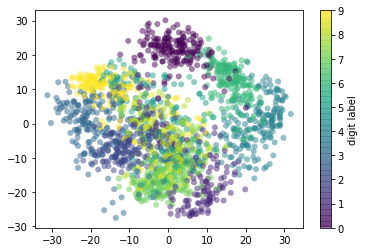

In [34]:
# Visualize the projected data
plt.scatter(X_proj[:, 0], # first dimension
            X_proj[:, 1], # second dimension
            c=y, # color by label
            edgecolor='none', # remove dot border
            alpha=0.5 # use transparency to better see overlapping dots
           ) 
plt.colorbar(label='digit label', ticks=range(10))

__Question__ What do you observe? Do you think the classification problem will be easy or hard?

__Réponse__ On observe des clusters en fonction de la valeur du digit. Par exemple, en haut au centre, sont regroupés les zéros. Néanmoins, certains clusters se superposent les uns les autres. Le problème ne sera donc pas si simple à résoudre.

A popular alternative to PCA, which projects the data linearly, is the [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) approach. It is very similar to run in scikit-learn:

In [35]:
from sklearn import manifold

In [36]:
# Create a tSNE object
tsne = manifold.TSNE(n_components=2)

# Apply to the data
X_proj = tsne.fit_transform(X)
print(X_proj.shape)

(1797, 2)


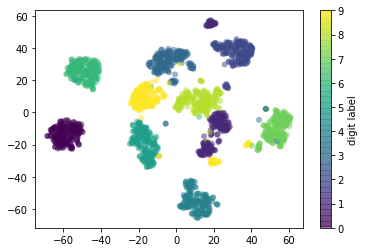

In [37]:
# Visualize the projected data
plt.scatter(X_proj[:, 0], # first dimension
            X_proj[:, 1], # second dimension
            c=y, # color by label
            edgecolor='none', # remove dot border
            alpha=0.5 # use transparency to better see overlapping dots
           ) 
plt.colorbar(label='digit label', ticks=range(10))

__Question__ What do you observe? Would you rather use the tSNE features or the PCA features for learning?

__Réponse__ Cette fois-ci, on observe toujours des clusters mais qui sont beaucoup plus regroupés avec moins de superposition. On sent alors qu'il vaudra mieux utiliser tSNE pour apprendre. Néanmoins, on a constaté que le fit_transform était beaucoup plus long pour tSNE, ce qui pourrait poser problème si le jeu de données d'apprentissage venait à trop grandir.

## 2. Clustering 
K-means is an algorithm for unsupervised clustering: that is, finding clusters (or groups) in data based on the data attributes alone (not the labels). K-means groups samples based on distances: points get assigned to the cluster to which they are the closest (based on the distance to the centroid), centroids are recomputed, and the procedure is iterated until convergence.

In k-means, the number of clusters k is a hyperparameter the user must provide.

Let us look at how it performs on the Digits data.

In [38]:
from sklearn import cluster

In [39]:
# create a k-means clustering object, for k=10
clustering = cluster.KMeans(10)

# apply it to the data
clusters = clustering.fit_predict(X)

Let us now look at the cluster centroids (i.e. the mean point of each cluster):

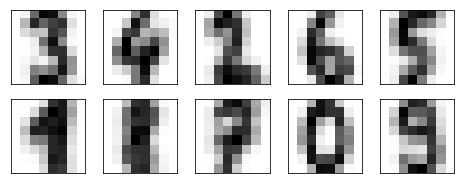

In [40]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(clustering.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

Even without the labels, the clustering algorithm has identified reasonable representants for each class!

Let us compare the clusters we obtained to the true labels. First, notice that the cluster centroids do not appear in the same order as the true labels (the first one is not necessarily a 1), because an unsupervised algorithm has no means to know what label we would like to assign to a cluster it found. We will start by reassigning cluster labels to match the most common digit in the cluster.

In [41]:
from scipy.stats import mode

pred_labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    pred_labels[mask] = mode(digits.target[mask])[0]

To compare these clusters to the true labels, we can look at their accuracy

In [42]:
from sklearn import metrics

In [43]:
print("Accuracy: %.2f" % metrics.accuracy_score(y, pred_labels))

Accuracy: 0.80


And look at the confusion matrix

In [44]:
print(metrics.confusion_matrix(y, pred_labels))

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   1 157   0   2   0   7   7   9]
 [  0   7   0   0 162   0   0   8   4   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   0   0   0   0   0   0 177   2   0]
 [  0   6   3   4   0   4   2   5 102  48]
 [  0  20   0   7   0   6   0   7   2 138]]


Text(0.5, 0, 'predicted')

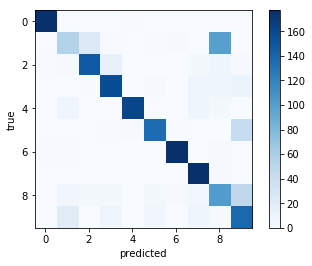

In [45]:
# Visualization
plt.imshow(metrics.confusion_matrix(y, pred_labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

__Question__ Which class was the most difficult to identify for the clustering algorithm? Does this match what you observed when looking at the centroids?

__Réponse__ La classe la plus difficile à identifier est la classe 1. En effet, très souvent, alors qu'il s'agissait d'un 1, l'algorithme a prédi un 8. Quand on regardait les centroides, on a effectivement constaté que le centroide du 8 était assez proche d'un 1.

We can also visualize the result of the clustering algorithm using the 2 tSNE dimensions.

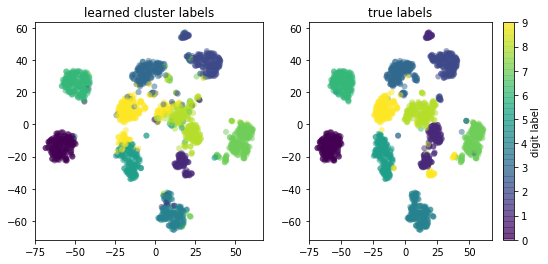

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# Plot 1
ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=pred_labels, 
             edgecolor='none', alpha=0.5)
ax[0].set_title('learned cluster labels')

# Plot 2
t = ax[1].scatter(X_proj[:, 0], X_proj[:, 1], c=y, 
             edgecolor='none', alpha=0.5)
ax[1].set_title('true labels')
plt.colorbar(t, label='digit label', ticks=range(10))

To get more distinct colors, you can use a different colormap:

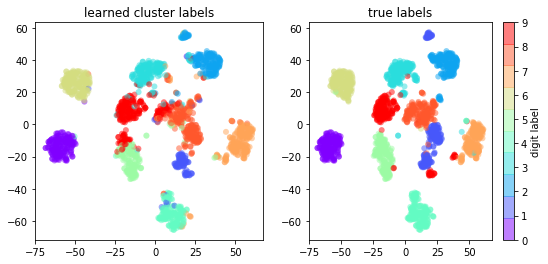

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# Plot 1
ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=pred_labels, 
             edgecolor='none', alpha=0.5,
             cmap = plt.cm.get_cmap('rainbow', 10))
ax[0].set_title('learned cluster labels')

# Plot 2
t = ax[1].scatter(X_proj[:, 0], X_proj[:, 1], c=y, 
             edgecolor='none', alpha=0.5,
             cmap = plt.cm.get_cmap('rainbow', 10))
ax[1].set_title('true labels')
plt.colorbar(t, label='digit label', ticks=range(10))

__Question__ Which digits are easy to predict? Which ones are confused with which other digits? Does this match the confusion matrix?

__Réponse__ On constate que les chiffres faciles à prédire sont ceux éloignés des autres et ayant peu d'erreurs en leur sein, c'est-à-dire 0, 2, 3, 4, 6 et 7. Ceux difficiles à prédire sont 1, 5, 8 et 9. Cela correspond bien à la matrice de confusion.

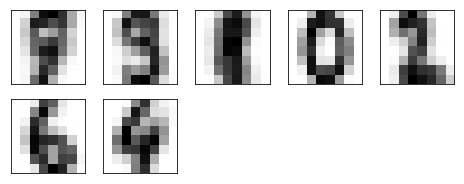

In [48]:
# create a k-means clustering object, for k=7
clustering = cluster.KMeans(7)

# apply it to the data
clusters = clustering.fit_predict(X)

fig = plt.figure(figsize=(8, 3))
for i in range(7):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(clustering.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)
    
pred_labels = np.zeros_like(clusters)

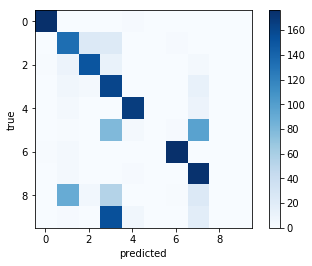

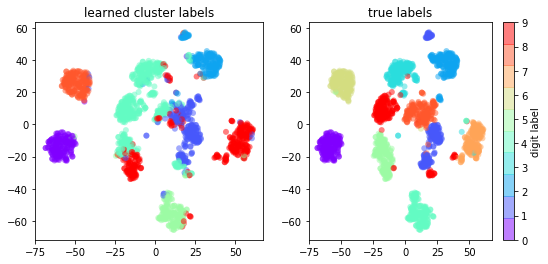

In [49]:
for i in range(10):
    mask = (clusters == i)
    pred_labels[mask] = mode(digits.target[mask])[0]

# Visualization
plt.imshow(metrics.confusion_matrix(y, pred_labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# Plot 1
ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=pred_labels, 
             edgecolor='none', alpha=0.5,
             cmap = plt.cm.get_cmap('rainbow', 10))
ax[0].set_title('learned cluster labels')

# Plot 2
t = ax[1].scatter(X_proj[:, 0], X_proj[:, 1], c=y, 
             edgecolor='none', alpha=0.5,
             cmap = plt.cm.get_cmap('rainbow', 10))
ax[1].set_title('true labels')
plt.colorbar(t, label='digit label', ticks=range(10))

__Question__ Reproduce this analysis using a different number of clusters (e.g. k=7) 

__Réponse__ En réduisant le nombre de clusters, on constate que certains clusters disparraissent. Notamment, l'algorithme ne se sert plus que de 0, 2, 4, 5, 7, 8, 9.

## 3. Classification
So, how well can we learn to separate these images using labeled data?

### 3.1 Model validation and selection
An very important part of machine learning is __model validation__: that is, determining how well your model will generalize from the training data to future unlabeled data. Using a simple algorithm that returns the stored label for any observation from the data set would result in very good predictions, but would not have _learned_ anything, and would be rubbish at predicting the label of a new handwritten digit.

We will therefore systematically split our data in a _training set_, on which we'll use the labels to _learn_, or _train_ the model, and a _test set_, on which we'll only use the labels to evaluate the model's ability to make correct predictions. __Not using test data at train time is absolutely essential to estimating generalization ability.__

In [50]:
from sklearn import model_selection 
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, random_state=42)

print(Xtrain.shape, Xtest.shape)

(1347, 64) (450, 64)


Using a fixed random seed (`random_state`) will ensure you can reproduce your experiments, i.e. always have the same samples in your train (resp. test) set. Someone running the experiments with the same seed on a different computer will have a different train/test split, though.

__Question__ What fraction of our data will we use for training? For testing?

__Réponse__ Nous allons utiliser 75% de nos données pour s'entraîner et 25% pour tester.

Suppose we want to choose between different machine learning algorithms, or between different values of the hyperparameters of the same algorithm. Of course, we can pick the model with the best performance on the test set. But how will we evaulate its performance?

__Question__ Why isn't the performance of the best-performing algorithm on the test set a good estimation of the generalization performance (i.e. performance on new data)?

__Réponse__ La performance sur notre ensemble test n'est pas forcément la meilleure estimation car il se peut que notre ensemble test ne soit pas représentatif de la réalité. Notre programme peut aussi être trop entraîné et ne reconnaître que ce qu'on lui a donné.

In this situation, it is common to use __cross-validation__ on the train set to select the best algorithm/model. The `sklearn.model_selection` module provides cross-validation facilities. In addition, many supervised learning algorithms of scikit-learn can be used with such an internal cross-validation procedure to select optimal hyperparameter(s).

## 3.2 Logistic regression 

[LogisticRegression documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[LogisticRegressionCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

The logistic regression implementation of scikit-learn minimizes C x logistic empirical error + regularization. Hence the non-regularized logistic regression is obtained when C is very large.

In [51]:
from sklearn import linear_model

# Create a logistic regression classifier
clf = linear_model.LogisticRegression(penalty='l2', 
                                      C=1e8,
                                      solver='lbfgs', multi_class='auto') # large value of C = no regularization

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

__Question__ What is the accuracy of this classifier? Display its confusion matrix.

The accuracy is: 0.986667


Text(0.5, 0, 'predicted')

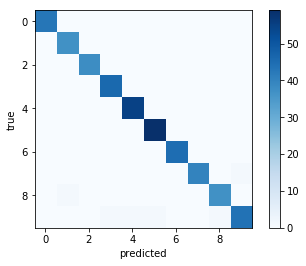

In [71]:
print("The accuracy is: %f" % clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

Can regularization improve this performance? Let us look at what happens when we change this parameter. We will use a cross-validation on the training set. 

In [62]:
import warnings
warnings.filterwarnings("ignore")

# Define a range of values for C
c_values = np.logspace(-5, 5, num=11)
print (c_values)

accuracies = [] # where to store mean accuracy for each value of C
for c_val in c_values:
    # create a logistic regression classifier
    clf = linear_model.LogisticRegression(penalty='l2', C=c_val, solver='lbfgs', multi_class='auto')
    
    # compute the 5-fold cross validation score of this classifier
    scores = model_selection.cross_val_score(clf, Xtrain, ytrain, 
                                             cv=5,
                                             scoring='accuracy')
    accuracies.append(np.mean(scores))

print(accuracies)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
[0.8522856563892136, 0.9213836201052568, 0.9428214286686352, 0.959857562607542, 0.9568312120501185, 0.9516562326369108, 0.9524052963073227, 0.9486846210539437, 0.9464565667058205, 0.9449500540895401, 0.9457182544230648]


Text(0.5, 0, 'Value of C')

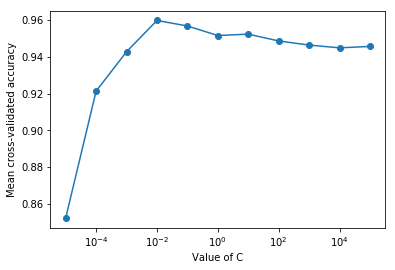

In [64]:
plt.semilogx(c_values, accuracies, marker='o') # plot using a log-scale on the x-axis
plt.ylabel('Mean cross-validated accuracy')
plt.xlabel('Value of C')

__Question__ What is the impact of having a very small C? Why?

__Réponse__ Avoir un trop petit C réduit la précision. La raison est la suivante : on ne prend en compte quasiment que la régulation, au détriment de ce que l'on veut véritablement minimiser.

Scikit-learn lets us tune the parameter C automatically, by cross-validation on the training set.

In [69]:
clf = linear_model.LogisticRegressionCV(Cs=10, 
                                        penalty='l2')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(clf.score(Xtest, ytest))

0.9688888888888889


__Question__ What values of C were tested? What is the accuracy now?

__Réponse__ On a testé 10 valeurs de C de 1e-4 à 1e4.

## 3.2 Nearest neighbors

[KNeighborsClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

The nearest neighbor algorithm classifies an observation according to the labels of the k nearest points in the training set.

In [67]:
from sklearn import neighbors

0.9866666666666667


Text(0.5, 0, 'predicted')

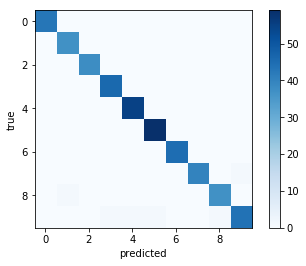

In [72]:
# Create a kNN classifier
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

print(clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

__Question__ What is the accuracy of this classifier? Display its confusion matrix. How does it compare to the logistic regression?

__Réponse__ Sur cette matrice de confusion, on sent que l'erreur diminue par rapport à la régression logistique.

Again, we have a hyperparameter to fit: the number of nearest neighbors.

Let us see how it impacts cross-validates performance on the training set.

In [80]:
# Define a range of values for k
k_values = np.array(np.linspace(2, 10, 10), dtype=int)
print(k_values)

[ 2  2  3  4  5  6  7  8  9 10]


In [81]:
accuracies = [] # where to store mean accuracy for each value of k
for k_val in k_values:
    # create a kNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors=k_val)
    
    # compute the 5-fold cross validation score of this classifier
    scores = model_selection.cross_val_score(clf, Xtrain, ytrain, 
                                             cv=10,
                                             scoring='accuracy')
    accuracies.append(np.mean(scores))

Text(0.5, 0, 'Value of k')

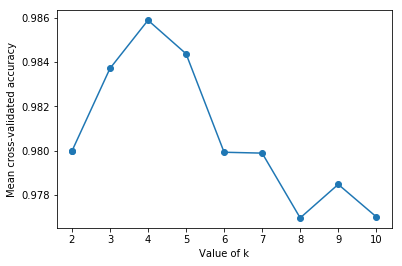

In [83]:
plt.plot(k_values, accuracies, marker='o') 
plt.ylabel('Mean cross-validated accuracy')
plt.xlabel('Value of k')

__Question__ What is the optimal number of nearest neighbors to use for this data?

__Réponse__ Le nombre optimal de voisins les plus proches est ici 4.

__Question__ Train a kNN that uses this optimal number of neighbors on the train set and evaluate it on the test set.

0.9866666666666667


Text(0.5, 0, 'predicted')

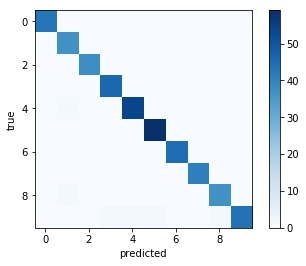

In [84]:
# Create a kNN classifier
clf = neighbors.KNeighborsClassifier(n_neighbors=4)

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

print(clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

## 3.3 SVM
### 3.3.1 Linear SVM

[LinearSVC documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

Let us start with a linear SVM.

In [85]:
from sklearn import svm

In [86]:
# Create a linear SVM classifier
clf = svm.LinearSVC(dual=False) # when number of samples > number of features, 
                                # solving the primal is more efficient.

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

In [87]:
print("Accuracy: %.3f" % metrics.accuracy_score(ytest, ypred))

Accuracy: 0.962


__Question__ What is the accuracy of this classifier? Display its confusion matrix. What was the value of the C parameter?

__Réponse__ Par défaut, la valeur de C est 1.

Text(0.5, 0, 'predicted')

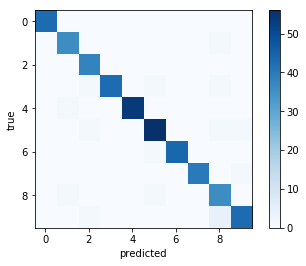

In [89]:
# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

We will now use a grid search to optimize the parameter C.

[GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [90]:
# define a grid (here, a line) of parameters to explore
param_grid = {'C': np.logspace(-5, 5, 11)}

# define the base classifier
clf = svm.LinearSVC(dual=False)

# define the grid search
gs = model_selection.GridSearchCV(clf, param_grid, cv=5, 
                                  scoring='accuracy')
# train
gs.fit(Xtrain, ytrain)

# print the best score and corresponding parameter
print("Best accuracy: %.3f" % gs.best_score_)
print("Optimal parameter:", gs.best_params_)

Best accuracy: 0.955
Optimal parameter: {'C': 0.001}


Information regarding the cross-validation experiment are stored in `gs.cv_results_`. 

In particular, we can observe how the mean cross-validated accuracy varies with C.

Text(0.5, 0, 'Value of C')

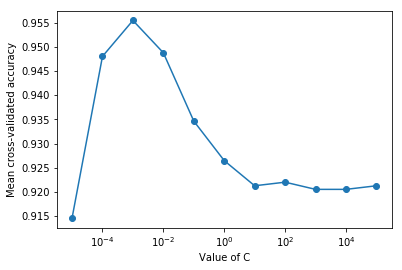

In [92]:
plt.semilogx(np.array(gs.cv_results_['param_C'], dtype='float'), 
             gs.cv_results_['mean_test_score'], marker='o') # plot using a log-scale on the x-axis
plt.ylabel('Mean cross-validated accuracy')
plt.xlabel('Value of C')

We can now train an SVM with optimal C parameter on the train set and evaluate it on the test set.

In [93]:
# Create a linear SVM classifier
clf = svm.LinearSVC(dual=False, C=gs.best_params_['C'])

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

__Question__ How does this classifier's accuracy compare to that of the logistic regression? Of the nearest neighbors? Look at the confusion matrix: is it always the same digits that are difficult to predict?

0.9733333333333334


Text(0.5, 0, 'predicted')

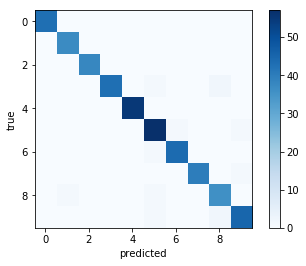

In [94]:
print(clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

### 3.3.2 Kernel SVM

Although our linear SVM already performs well, the power of SVMs typically come from their ability to solve the problem in a non-linear way, thanks to a kernel.

[SVC documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


In [95]:
# Create an RBF SVM classifier
clf = svm.SVC(kernel='rbf') 

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

__Question__ What is the accuracy of this classifier? 

0.5222222222222223


Text(0.5, 0, 'predicted')

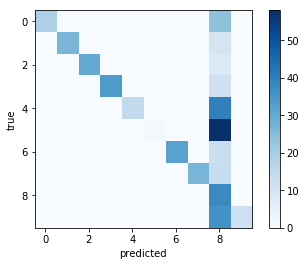

In [96]:
print(clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

__Question__ Choose two parameters to optimize to try and improve this performance.

1.438449888287663e-05


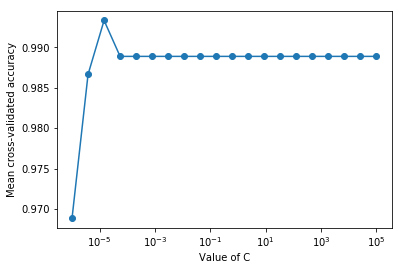

In [104]:
c_values = np.logspace(-6, 5, num=20)

accuracies = []

for c_value in c_values:
    # Create an RBF SVM classifier
    clf = svm.SVC(kernel='poly', C=c_value) 

    # Fit the classifier on train data
    clf.fit(Xtrain, ytrain)

    # Apply the classifier to test data
    ypred = clf.predict(Xtest)
    
    accuracies.append(clf.score(Xtest, ytest))

plt.semilogx(c_values, accuracies, marker='o') # plot using a log-scale on the x-axis
plt.ylabel('Mean cross-validated accuracy')
plt.xlabel('Value of C')

print(c_values[argmax(accuracies)])

__Question__ Train the model with optimal parameters on the train set and evaluate it on the test set. Compare it to the previous models.

0.9933333333333333


Text(0.5, 0, 'predicted')

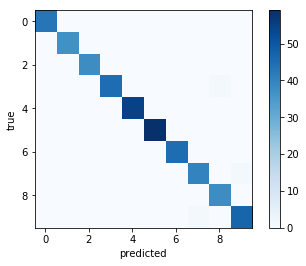

In [111]:
# Create an RBF SVM classifier
c = 1.438449888287663e-5

clf = svm.SVC(kernel='poly', C=c) 

# Fit the classifier on train data
clf.fit(Xtrain, ytrain)

# Apply the classifier to test data
ypred = clf.predict(Xtest)

print(clf.score(Xtest, ytest))

# Visualization
plt.imshow(metrics.confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

## 3.4 Random forests

[RandomForestClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Now you can try applying random forests to the Digits data. Refer to the documentation to create and evaluate a random forest classifier with default parameter, as well as to choose which parameters to optimize.